In [1]:
import os
import glob

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, udf, explode, collect_list, array
from pyspark.sql.types import StringType
from pyspark.sql import functions as F

from utils.mongodb_to_parquet import get_pyspark_session
from utils.gdrive_utils import connect_to_gdrive, sync_gdrive_db_to_local

from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, FloatType
from rapidfuzz import process, fuzz

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data

## Import parquet-ified resumes & JD

In [2]:
spark = get_pyspark_session()

:: loading settings :: url = jar:file:/usr/local/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c132727a-cb12-4455-be8d-897aa78ff30d;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.5.0 in central
	found org.mongodb#mongodb-driver-sync;5.1.4 in central
	[5.1.4] org.mongodb#mongodb-driver-sync;[5.1.1,5.1.99)
	found org.mongodb#bson;5.1.4 in central
	found org.mongodb#mongodb-driver-core;5.1.4 in central
	found org.mongodb#bson-record-codec;5.1.4 in central
:: resolution report :: resolve 3733ms :: artifacts dl 10ms
	:: modules in use:
	org.mongodb#bson;5.1.4 from central in [default]
	org.mongodb#bson-record-codec;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-core;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-sync;5.1.4 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;10.5.0 f

In [3]:
def read_silver_table(table, silver_db, spark):
    """
    Helper function to read all partitions of a silver table
    """
    folder_path = os.path.join(silver_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df

In [5]:
df_jd = read_silver_table('job_descriptions', 'datamart/silver', spark)
df_resumes = read_silver_table('resumes', 'datamart/silver', spark)
df_labels = read_silver_table('labels', 'datamart/silver', spark)

In [6]:
# Select relevant columns for skill processing
df_resumes_skills = df_resumes.select('id', 'hard_skills', 'soft_skills') 
df_jd_skills = df_jd.select('id', 'required_hard_skills', 'required_soft_skills')

In [7]:
# Convert to lowercase
df_resumes_skills = df_resumes_skills.withColumn("hard_skills", expr("transform(hard_skills, x -> lower(x))"))
df_resumes_skills = df_resumes_skills.withColumn("soft_skills", expr("transform(soft_skills, x -> lower(x))"))

df_jd_skills = df_jd_skills.withColumn("hard_skills", expr("transform(required_hard_skills, x -> lower(x))"))
df_jd_skills = df_jd_skills.withColumn("soft_skills", expr("transform(required_soft_skills, x -> lower(x))"))

## Import skills list silver table

In [11]:
sync_gdrive_db_to_local()

Download complete.


# Skills Standardization

In [8]:
df_hard_skills_keywords = read_silver_table('hardskill', 'datamart/silver', spark)
df_hard_skills_keywords.show()

+----------+--------------------+--------------------+
|keyword_id|             keyword|             example|
+----------+--------------------+--------------------+
|  43232202|document manageme...|adobe systems ado...|
|  43232306|data base user in...|     adsense tracker|
|  43232201|content workflow ...|      atlassian jira|
|  43232303|customer relation...|blackbaud the rai...|
|  43231601| accounting software|computerease cons...|
|  43232305|data base reporti...|database reportin...|
|  43232306|data base user in...|             databox|
|  43233501|electronic mail s...|      email software|
|  43231602|enterprise resour...|enterprise resour...|
|  43231605|time accounting s...|exact software ma...|
|  43232403|enterprise applic...|extensible markup...|
|  43231601| accounting software|fund accounting s...|
|  43232102|graphics or photo...|graphic presentat...|
|  43231505|human resources s...|        halogen e360|
|  43231505|human resources s...|    halogen epraisal|
|  4323150

In [ ]:
# df_soft_skills_keywords = read_silver_table('softskill', 'datamart/silver', spark)
# df_soft_skills_keywords.show()

+----------+--------------------+--------------------+
|keyword_id|             keyword|            examples|
+----------+--------------------+--------------------+
|   2.a.1.a|reading comprehen...| getting information|
|   2.a.1.a|reading comprehen...|monitor processes...|
|   2.a.1.a|reading comprehen...|identifying objec...|
|   2.a.1.a|reading comprehen...|judging the quali...|
|   2.a.1.a|reading comprehen...|processing inform...|
|   2.a.1.a|reading comprehen...|evaluating inform...|
|   2.a.1.a|reading comprehen...|analyzing data or...|
|   2.a.1.a|reading comprehen...|making decisions ...|
|   2.a.1.a|reading comprehen...|updating and usin...|
|   2.a.1.a|reading comprehen...|interacting with ...|
|   2.a.1.a|reading comprehen...|drafting, laying ...|
|   2.a.1.a|reading comprehen...|interpreting the ...|
|   2.a.1.a|reading comprehen...|training and teac...|
|   2.a.1.a|reading comprehen...|provide consultat...|
|   2.a.1.a|reading comprehen...|performing admini...|
|   2.a.1.

## Fuzzy Matching

In [79]:
# df_resumes_skills = df_resumes_skills.withColumnRenamed("id", "resume_id")
# df_jd_skills = df_jd_skills.withColumnRenamed("id", "job_id")
# df_joined = df_labels.join(df_resumes_skills, on="resume_id", how="inner") 
# df_joined = df_joined.join(df_jd_skills, on="job_id", how="inner")
# df_joined.show()

In [9]:
def fuzzy_match_array_udf_factory(mapping_dict):
    def match_array(arr):
        keyword_matches = []
        example_matches = []
        scores = []

        reference_values = list(mapping_dict.keys())
        reference_categories = list(mapping_dict.values())
        
        if arr:
            for x in arr:
                if x:
                    match = process.extractOne(x, reference_values, scorer=fuzz.token_set_ratio)
                    score = float(match[1])
                    if match and score > 80:
                        example_matches.append(match[0])
                        keyword_matches.append(mapping_dict[match[0]])
                        scores.append(score)  # similarity score as float
                    else:
                        match = process.extractOne(x, reference_categories, scorer=fuzz.token_set_ratio)
                        score = float(match[1])
                        if match and score > 80:
                            example_matches.append(None)
                            keyword_matches.append(match[0])
                            scores.append(score)
                        else:
                            example_matches.append(None)
                            keyword_matches.append(None)
                            scores.append(None)
                else:
                    keyword_matches.append(None)
                    example_matches.append(None)
                    scores.append(None)
            return keyword_matches, example_matches, scores
        return None
    
    schema = StructType([
        StructField("keyword_matches", ArrayType(StringType()), nullable=True),
        StructField("example_matches", ArrayType(StringType()), nullable=True),
        StructField("scores", ArrayType(FloatType()), nullable=True)
    ])
    
    return udf(match_array, schema)


In [ ]:
# import math

# def fuzzy_match_array_udf_factory(reference_values):
#     counts = Counter(reference_values)
#     weighted_choices = [(k, int(v)) for k, v in counts.items()]

#     max_weight = counts.most_common(1)[0][1]

#     def match_array(arr):
#         matches = []
#         scores = []
        
#         if arr:
#             for item in arr:
#                 best_match = None
#                 best_score = -1.0
#                 best_original_score = -1.0
#                 if item:
#                     for ref, weight in weighted_choices:
#                         original_score = fuzz.ratio(item, ref)
#                         score = fuzz.ratio(item, ref) + math.log(weight)
#                         if score > best_score:
#                             best_score = score
#                             best_original_score = original_score
#                             best_match = ref
#                 matches.append(best_match)
#                 scores.append(best_original_score)
#             return matches, scores
#         return None
    
#     schema = StructType([
#         StructField("matches", ArrayType(StringType()), nullable=True),
#         StructField("scores", ArrayType(FloatType()), nullable=True)
#     ])
    
#     return udf(match_array, schema)


### Hard skills convert to keywords

**Standardize Resume**

In [10]:
mapping_dict = dict(df_hard_skills_keywords.rdd.map(lambda row: (row['example'], row['keyword'])).collect())

fuzzy_match_udf = fuzzy_match_array_udf_factory(mapping_dict)

df_matched_resume = df_resumes_skills.withColumn("hard_skills_fuzzy", fuzzy_match_udf("hard_skills"))

df_matched_resume = df_matched_resume \
    .withColumn("hard_skills_category", df_matched_resume["hard_skills_fuzzy"]["keyword_matches"]) \
    .withColumn("hard_skills_standardized", df_matched_resume["hard_skills_fuzzy"]["example_matches"]) \
    .withColumn("hard_skills_similarity_scores", df_matched_resume["hard_skills_fuzzy"]["scores"]) \
    .drop("hard_skills_fuzzy")

df_matched_resume.show()

+------------+--------------------+--------------------+--------------------+------------------------+-----------------------------+
|          id|         hard_skills|         soft_skills|hard_skills_category|hard_skills_standardized|hard_skills_similarity_scores|
+------------+--------------------+--------------------+--------------------+------------------------+-----------------------------+
|RES_s93wTCLp|[atm, c++, ccna, ...|[clients, procure...|[NULL, object or ...|    [NULL, c++, NULL,...|         [NULL, 100.0, NUL...|
|RES_Z7yf1tu6|[sql, pl/sql, tra...|[communication, t...|[data base user i...|    [structured query...|         [100.0, 100.0, 10...|
|RES_hAp1XnJZ|[database design,...|[excellent commun...|[data base manage...|    [database design ...|         [100.0, NULL, NUL...|
|RES_zsgGxd2s|[microsoft access...|[collaboration, c...|[data base user i...|    [microsoft access...|         [100.0, 100.0, NU...|
|RES_RrDNNvMz|[r, sql, data ana...|[innovative, deta...|[object or co

In [10]:
df_matched_resume.write.parquet("datamart/temp/df_matched_resume.parquet")

**Standardize JD**

In [11]:
mapping_dict = dict(df_hard_skills_keywords.rdd.map(lambda row: (row['example'], row['keyword'])).collect())

fuzzy_match_udf = fuzzy_match_array_udf_factory(mapping_dict)

df_matched_jd = df_jd_skills.withColumn("hard_skills_fuzzy", fuzzy_match_udf("hard_skills"))

df_matched_jd = df_matched_jd \
    .withColumn("hard_skills_category", df_matched_jd["hard_skills_fuzzy"]["keyword_matches"]) \
    .withColumn("hard_skills_standardized", df_matched_jd["hard_skills_fuzzy"]["example_matches"]) \
    .withColumn("hard_skills_similarity_scores", df_matched_jd["hard_skills_fuzzy"]["scores"]) \
    .drop("hard_skills_fuzzy")

df_matched_jd.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+-----------------------------+
|         id|required_hard_skills|required_soft_skills|         hard_skills|         soft_skills|hard_skills_category|hard_skills_standardized|hard_skills_similarity_scores|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+-----------------------------+
|JD_kQiZZseA|[Data Quality Mod...|[Working with Mat...|[data quality mod...|[working with mat...|[NULL, data base ...|    [NULL, structured...|         [NULL, 100.0, NUL...|
|JD_Xr9WwV9E|[Java, J2EE, Spri...|[Communication, T...|[java, j2ee, spri...|[communication, t...|[object or compon...|    [oracle java, ora...|         [100.0, 100.0, 10...|
|JD_NP2XGlwL|[MS Excel (includ...|[Detail-oriented,...|[ms excel (includ...|[detail-oriented,...|[NULL, data minin...|    [NULL, b

In [12]:
df_matched_jd.write.parquet("datamart/temp/df_matched_jd.parquet")

In [84]:

# # reference_list = ["java", "python", "sql", "machine learning"]

# # def fuzzy_match_array_udf_factory(reference_values):
# #     def match_array(arr):
# #         if arr:
# #             # For each element, find the best fuzzy match in reference_values
# #             return [process.extractOne(x, reference_values)[0] if x else None for x in arr]
# #         return None
# #     return udf(match_array, ArrayType(StringType()))


# # Only the match
# # def fuzzy_match_array_udf_factory():
# #     def match_array(arr1, arr2):
# #         if arr1 and arr2:
# #             return [
# #                 process.extractOne(x, arr2)[0] if x else None
# #                 for x in arr1
# #             ]
# #         return None
# #     return udf(match_array, ArrayType(StringType()))

# # Match and score
# def fuzzy_match_array_udf_factory():
#     def match_array(arr1, arr2):
#         if arr1 and arr2:
#             matches = []
#             scores = []
#             for x in arr1:
#                 if x:
#                     match = process.extractOne(x, arr2)
#                     if match:
#                         matches.append(match[0])
#                         scores.append(float(match[1]))  # similarity score as float
#                     else:
#                         matches.append(None)
#                         scores.append(None)
#                 else:
#                     matches.append(None)
#                     scores.append(None)
#             return matches, scores
#         return None, None
    
#     schema = StructType([
#         StructField("matches", ArrayType(StringType()), nullable=True),
#         StructField("scores", ArrayType(FloatType()), nullable=True)
#     ])
#     return udf(match_array, schema)


# fuzzy_match_udf = fuzzy_match_array_udf_factory()

# df_matched = df_joined.withColumn("hard_skills_fuzzy", fuzzy_match_udf("hard_skills", "required_hard_skills"))

# df_matched = df_matched \
#     .withColumn("hard_skills_matched", df_matched["hard_skills_fuzzy"]["matches"]) \
#     .withColumn("hard_skills_similarity_scores", df_matched["hard_skills_fuzzy"]["scores"]) \
#     .drop("hard_skills_fuzzy")

# df_matched.show()


In [12]:
row = df_matched_resume.filter(df_matched_resume.id == "RES_AWfs9B9f").first().asDict()
for skill, category, keyword, score in zip(row['hard_skills'],
                        row['hard_skills_category'], 
                        row['hard_skills_standardized'],
                        row['hard_skills_similarity_scores']):
    print(f"Original skill: {skill}, Matched category: {category}, Keyword: {keyword}, Score: {score}"  )

Original skill: mssql, Matched category: None, Keyword: None, Score: None
Original skill: c#, Matched category: object or component oriented development software, Keyword: c#, Score: 100.0
Original skill: asp.net mvc, Matched category: web platform development software, Keyword: microsoft asp.net core mvc, Score: 100.0
Original skill: web api, Matched category: None, Keyword: None, Score: None
Original skill: entity framework, Matched category: None, Keyword: None, Score: None
Original skill: ado.net, Matched category: data base user interface and query software, Keyword: ado.net, Score: 100.0
Original skill: test driven development, Matched category: None, Keyword: None, Score: None
Original skill: domain driven design, Matched category: None, Keyword: None, Score: None
Original skill: n tier architecture, Matched category: None, Keyword: None, Score: None
Original skill: sql server, Matched category: data base user interface and query software, Keyword: microsoft sql server, Score: 1

In [13]:
row = df_matched_jd.filter(df_matched_jd.id == "JD_AWfs9B9f").first().asDict()
for skill, category, keyword, score in zip(row['hard_skills'],
                        row['hard_skills_category'], 
                        row['hard_skills_standardized'],
                        row['hard_skills_similarity_scores']):
    print(f"Original skill: {skill}, Matched category: {category}, Keyword: {keyword}, Score: {score}"  )

Original skill: php, Matched category: web platform development software, Keyword: hypertext preprocessor php, Score: 100.0
Original skill: cms systems (wordpress, drupal, shopify, squarespace, joomla), Matched category: None, Keyword: None, Score: None
Original skill: php frameworks (slim, laravel, symfony), Matched category: None, Keyword: None, Score: None
Original skill: javascript/node, Matched category: None, Keyword: None, Score: None
Original skill: javascript frameworks (react/react native, sencha, vue.js), Matched category: web platform development software, Keyword: javascript, Score: 100.0
Original skill: relational databases (mysql), Matched category: None, Keyword: None, Score: None
Original skill: nosql databases (mongodb), Matched category: data base management system software, Keyword: nosql, Score: 100.0
Original skill: key-value databases (redis), Matched category: None, Keyword: None, Score: None
Original skill: api development, Matched category: development environ

### Soft skills convert to keywords

In [ ]:
# soft_skills_ref = df_soft_skills_keywords.select("keyword").dropDuplicates().rdd.flatMap(lambda x: x).collect()

# fuzzy_match_udf = fuzzy_match_array_udf_factory(soft_skills_ref)

# df_matched_soft = df_resumes_skills.withColumn("soft_skills_fuzzy", fuzzy_match_udf("soft_skills"))

# df_matched_soft = df_matched_soft \
#     .withColumn("soft_skills_matched", df_matched_soft["soft_skills_fuzzy"]["matches"]) \
#     .withColumn("soft_skills_similarity_scores", df_matched_soft["soft_skills_fuzzy"]["scores"]) \
#     .drop("soft_skills_fuzzy")

# df_matched_soft.show()

+------------+--------------------+--------------------+--------------------+-----------------------------+
|          id|         hard_skills|         soft_skills| soft_skills_matched|soft_skills_similarity_scores|
+------------+--------------------+--------------------+--------------------+-----------------------------+
|RES_s93wTCLp|[atm, c++, ccna, ...|[clients, procure...|[active listening...|         [43.47826, 38.461...|
|RES_Z7yf1tu6|[sql, pl/sql, tra...|[communication, t...|[coordination, sp...|         [64.0, 37.5, 40.0...|
|RES_hAp1XnJZ|[database design,...|[excellent commun...|[service orientat...|         [44.89796, 48.780...|
|RES_zsgGxd2s|[microsoft access...|[collaboration, c...|[coordination, se...|         [72.0, 60.869564,...|
|RES_RrDNNvMz|[r, sql, data ana...|[innovative, deta...|[service orientat...|         [48.275864, 47.05...|
|RES_7rYoKTcb|[matlab, simulink...|[communication, t...|[coordination, sp...|         [64.0, 37.5, 40.0...|
|RES_dI74kKQw|[html, html5, 

In [ ]:
# row = df_matched_soft.filter(df_matched_soft.id == "RES_mSxlSENu").first().asDict()
# for skill, match, score in zip(row['soft_skills'],
#                         row['soft_skills_matched'], 
#                         row['soft_skills_similarity_scores']):
#     print(f"Original skill: {skill}, Matched word: {match}, Score: {score}"  )

Original skill: communication, Matched word: coordination, Score: 64.0
Original skill: teamwork, Matched word: speaking, Score: 37.5
Original skill: leadership, Matched word: active learning, Score: 40.0
Original skill: problem-solving, Matched word: complex problem solving, Score: 73.68421173095703
Original skill: analytical skills, Matched word: critical thinking, Score: 47.05882263183594
Original skill: project management, Matched word: time management, Score: 80.0
Original skill: client handling, Matched word: active learning, Score: 60.0
Original skill: written communication skills, Matched word: service orientation, Score: 51.0638313293457


## Embedding

In [ ]:
# from langchain_core.vectorstores import InMemoryVectorStore
# from langchain_mistralai import MistralAIEmbeddings

# def embed_match_array_udf_factory(keywords_list):
#     def match_array(arr):
#         embeddings = MistralAIEmbeddings(model="mistral-embed")
   
#         vectorstore = InMemoryVectorStore.from_texts(
#             keywords_list,
#             embedding=embeddings
#         )
        
#         if arr:
#             matches = []
#             scores = []

#             for x in arr:
#                 if x:
#                     result = vectorstore.similarity_search_with_score(x, k=1)
#                     top_doc, score = result[0]

#                     matches.append(top_doc.page_content)
#                     scores.append(score)

#             return matches, scores
#         return None, None
        
#     schema = StructType([
#         StructField("matches", ArrayType(StringType()), nullable=True),
#         StructField("scores", ArrayType(FloatType()), nullable=True)
#     ])
    
#     return udf(match_array, schema)


In [ ]:
# soft_skills_ref = df_soft_skills_keywords.select("keyword").dropDuplicates().rdd.flatMap(lambda x: x).collect()

# embed_match_udf = embed_match_array_udf_factory(soft_skills_ref)

# df_matched_soft = df_resumes_skills.withColumn("soft_skills_embed", embed_match_udf("soft_skills"))

# df_matched_soft = df_matched_soft \
#     .withColumn("soft_skills_matched", df_matched_soft["soft_skills_embed"]["matches"]) \
#     .withColumn("soft_skills_similarity_scores", df_matched_soft["soft_skills_embed"]["scores"]) \
#     .drop("soft_skills_embed")

# df_matched_soft.show()

/usr/local/lib/python3.12/site-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


+------------+--------------------+--------------------+--------------------+-----------------------------+
|          id|         hard_skills|         soft_skills| soft_skills_matched|soft_skills_similarity_scores|
+------------+--------------------+--------------------+--------------------+-----------------------------+
|RES_s93wTCLp|[atm, c++, ccna, ...|[clients, procure...|[writing, negotia...|         [0.6538537, 0.714...|
|RES_Z7yf1tu6|[sql, pl/sql, tra...|[communication, t...|[speaking, coordi...|         [0.7909141, 0.760...|
|RES_hAp1XnJZ|[database design,...|[excellent commun...|[active listening...|         [0.74233043, 0.72...|
|RES_zsgGxd2s|[microsoft access...|[collaboration, c...|[coordination, se...|         [0.7823948, 0.755...|
|RES_RrDNNvMz|[r, sql, data ana...|[innovative, deta...|[critical thinkin...|         [0.6805059, 0.726...|
|RES_7rYoKTcb|[matlab, simulink...|[communication, t...|[speaking, coordi...|         [0.7909141, 0.760...|
|RES_dI74kKQw|[html, html5, 

In [ ]:
# row = df_matched_soft.filter(df_matched_soft.id == "RES_mSxlSENu").first().asDict()
# for skill, match, score in zip(row['soft_skills'],
#                         row['soft_skills_matched'], 
#                         row['soft_skills_similarity_scores']):
#     print(f"Original skill: {skill}, Matched word: {match}, Score: {score}"  )

/usr/local/lib/python3.12/site-packages/langchain_mistralai/embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


Original skill: communication, Matched word: speaking, Score: 0.7909141182899475
Original skill: teamwork, Matched word: coordination, Score: 0.7602235078811646
Original skill: leadership, Matched word: critical thinking, Score: 0.747788667678833
Original skill: problem-solving, Matched word: complex problem solving, Score: 0.8326230049133301
Original skill: analytical skills, Matched word: critical thinking, Score: 0.777920126914978
Original skill: project management, Matched word: time management, Score: 0.82828289270401
Original skill: client handling, Matched word: management of personnel resources, Score: 0.6217860579490662
Original skill: written communication skills, Matched word: writing, Score: 0.7942733764648438


# Gold Table

In [72]:
df_resumes_skills_rename = df_resumes_skills.withColumnRenamed("id", "resume_id")
df_jd_skills_rename = df_jd_skills.withColumnRenamed("id", "job_id").withColumnRenamed('soft_skills', 'jd_soft_skills')
df_joined = df_labels.join(df_resumes_skills_rename, on="resume_id", how="inner") 
df_joined = df_joined.join(df_jd_skills_rename, on="job_id", how="inner")
df_joined = df_joined.select('job_id', 'resume_id', 'fit', 'soft_skills', 'jd_soft_skills')
df_joined.show()

+-----------+------------+------+--------------------+--------------------+
|     job_id|   resume_id|   fit|         soft_skills|      jd_soft_skills|
+-----------+------------+------+--------------------+--------------------+
|JD_s93wTCLp|RES_s93wTCLp|No Fit|[clients, procure...|                  []|
|JD_Z7yf1tu6|RES_Z7yf1tu6|No Fit|[communication, t...|[communication, t...|
|JD_hAp1XnJZ|RES_hAp1XnJZ|No Fit|[excellent commun...|[facilitation, st...|
|JD_zsgGxd2s|RES_zsgGxd2s|No Fit|[collaboration, c...|[facilitation, st...|
|JD_RrDNNvMz|RES_RrDNNvMz|No Fit|[innovative, deta...|[communication, c...|
|JD_7rYoKTcb|RES_7rYoKTcb|No Fit|[communication, t...|[communication, t...|
|JD_dI74kKQw|RES_dI74kKQw|No Fit|[project leadersh...|                  []|
|JD_AAwaK8NY|RES_AAwaK8NY|No Fit|[communication, p...|[communication, t...|
|JD_jxAmUMgn|RES_jxAmUMgn|No Fit|[account manageme...|                  []|
|JD_fTYeywv1|RES_fTYeywv1|No Fit|[managing, counse...|[communication, a...|
|JD_ZZpNAyeK

In [ ]:
# import spacy.cli
# spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 402.9 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [73]:
columns = df_joined.columns

def process_partition(rows):
    import spacy
    # spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

    GENERIC_NOUNS = {
        "skill", "skills", "ability", "abilities", "knowledge",
        "proficiency", "understanding", "capability", "competency"
    }

    def extract_head_noun(text):
        doc = nlp(text)
        for chunk in doc.noun_chunks:
            for token in chunk:
                if token.pos_ == "NOUN" and token.lemma_ not in GENERIC_NOUNS:
                    return token.lemma_
        return text

    for row in rows:
        row = row.asDict()
        row["soft_skills"] = [extract_head_noun(s) for s in row["soft_skills"]]
        row["jd_soft_skills"] = [extract_head_noun(s) for s in row["jd_soft_skills"]]
        yield tuple(row[col] for col in columns)

df_joined = df_joined.rdd.mapPartitions(process_partition).toDF(columns)
df_joined.show()

+-----------+------------+------+--------------------+--------------------+
|     job_id|   resume_id|   fit|         soft_skills|      jd_soft_skills|
+-----------+------------+------+--------------------+--------------------+
|JD_s93wTCLp|RES_s93wTCLp|No Fit|[client, procurem...|                  []|
|JD_Z7yf1tu6|RES_Z7yf1tu6|No Fit|[communication, t...|[communication, t...|
|JD_hAp1XnJZ|RES_hAp1XnJZ|No Fit|[communication, s...|[facilitation, an...|
|JD_zsgGxd2s|RES_zsgGxd2s|No Fit|[collaboration, c...|[facilitation, an...|
|JD_RrDNNvMz|RES_RrDNNvMz|No Fit|[innovative, deta...|[communication, c...|
|JD_7rYoKTcb|RES_7rYoKTcb|No Fit|[communication, t...|[communication, t...|
|JD_dI74kKQw|RES_dI74kKQw|No Fit|[project, managem...|                  []|
|JD_AAwaK8NY|RES_AAwaK8NY|No Fit|[communication, p...|[communication, t...|
|JD_jxAmUMgn|RES_jxAmUMgn|No Fit|[account, agile, ...|                  []|
|JD_fTYeywv1|RES_fTYeywv1|No Fit|[managing, counse...|[communication, a...|
|JD_ZZpNAyeK

In [14]:
from langchain_core.vectorstores import InMemoryVectorStore
from sklearn.metrics.pairwise import cosine_similarity
# from langchain_mistralai import HuggingFaceEmbeddings
import numpy as np


def embed_compare_array_udf_factory():
    # Force download SentenceTransformer
    embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    cache_dir = "cache/sentence-transformers/all-MiniLM-L6-v2"
    embeddings.save(cache_dir)

    def match_array(arr1, arr2):
        if arr1 and arr2:
            embeddings = SentenceTransformer(cache_dir)
        
            arr1_vectors = embeddings.encode(arr1, normalize_embeddings=True)
            arr2_vectors = embeddings.encode(arr2, normalize_embeddings=True)

            similarities = cosine_similarity(arr2_vectors, arr1_vectors)

            matches = []
            scores = []

            for i, row in enumerate(similarities):
                best_idx = np.argmax(row)
                best_score = row[best_idx]

                if best_score > 0:
                    matches.append(arr1[best_idx])
                    scores.append(float(best_score))
                else:
                    matches.append(None)
                    scores.append(None)

            return matches, scores
        return None, None
        
    schema = StructType([
        StructField("matches", ArrayType(StringType()), nullable=True),
        StructField("scores", ArrayType(FloatType()), nullable=True)
    ])
    
    return udf(match_array, schema)


In [33]:
from pyspark.sql.functions import pandas_udf

def embed_compare_array_pandas_udf_factory():
    
    schema = StructType([
        StructField("matches", ArrayType(StringType()), nullable=True),
        StructField("scores", ArrayType(FloatType()), nullable=True)
    ])

    @pandas_udf(schema)
    def match_batch(arr1_series: pd.Series, arr2_series: pd.Series) -> pd.DataFrame:
        embedder = MistralAIEmbeddings(model="mistral-embed")

        # Step 1: Flatten all arr1 and arr2 into one big list
        arr1_all = []
        arr2_all = []
        arr1_lens = []
        arr2_lens = []

        for arr1, arr2 in zip(arr1_series, arr2_series):
            arr1_lens.append(len(arr1) if arr1 else 0)
            arr2_lens.append(len(arr2) if arr2 else 0)
            arr1_all.extend(arr1 or [])
            arr2_all.extend(arr2 or [])

        # Step 2: Embed all at once (1 batch for arr1, 1 for arr2)
        arr1_all_vecs = embedder.embed_documents(arr1_all) if arr1_all else []
        arr2_all_vecs = embedder.embed_documents(arr2_all) if arr2_all else []

        # Step 3: Reconstruct vectors per row
        arr1_vectors_per_row = []
        arr2_vectors_per_row = []

        a1_offset = 0
        a2_offset = 0

        for l1, l2 in zip(arr1_lens, arr2_lens):
            arr1_vectors_per_row.append(arr1_all_vecs[a1_offset:a1_offset+l1] if l1 > 0 else [])
            arr2_vectors_per_row.append(arr2_all_vecs[a2_offset:a2_offset+l2] if l2 > 0 else [])
            a1_offset += l1
            a2_offset += l2

        results = []

        for arr1, arr2, arr1_vecs, arr2_vecs in zip(arr1_series, arr2_series, arr1_vectors_per_row, arr2_vectors_per_row):
            if not arr1 or not arr2:
                results.append(([], []))
                continue

            sim_matrix = cosine_similarity(arr2_vecs, arr1_vecs)

            matches = []
            scores = []

            for i, row in enumerate(sim_matrix):
                best_idx = int(np.argmax(row))
                best_score = float(row[best_idx])
                if best_score > 0.8:
                    matches.append(arr1[best_idx])
                    scores.append(best_score)
                else:
                    matches.append(None)
                    scores.append(None)

            results.append((matches, scores))

        return pd.DataFrame(results, columns=["matches", "scores"])

    return match_batch

In [14]:
def fuzzy_compare_array_udf_factory():
    def match_array(arr1, arr2):
        if arr1 and arr2:
            matches = []
            scores = []
            for x in arr2:
                if x:
                    match = process.extractOne(x, arr1, scorer=fuzz.WRatio)
                    score = float(match[1])
                    if match and score > 80:
                        matches.append(match[0])
                        scores.append(score)  
                    else:
                        matches.append(None)
                        scores.append(None)
                else:
                    matches.append(None)
                    scores.append(None)
            return matches, scores
        return [], []
    
    schema = StructType([
        StructField("matches", ArrayType(StringType()), nullable=True),
        StructField("scores", ArrayType(FloatType()), nullable=True)
    ])
    return udf(match_array, schema)

In [74]:
embed_compare_udf = embed_compare_array_udf_factory()

df_compare_soft = df_joined.withColumn("soft_skills_compare", embed_compare_udf("soft_skills", "jd_soft_skills"))

df_compare_soft = df_compare_soft \
    .withColumn("soft_skills_matched", df_compare_soft["soft_skills_compare"]["matches"]) \
    .withColumn("soft_skills_similarity_scores", df_compare_soft["soft_skills_compare"]["scores"]) \
    .drop("soft_skills_compare")

df_compare_soft.show()

+-----------+------------+------+--------------------+--------------------+--------------------+-----------------------------+
|     job_id|   resume_id|   fit|         soft_skills|      jd_soft_skills| soft_skills_matched|soft_skills_similarity_scores|
+-----------+------------+------+--------------------+--------------------+--------------------+-----------------------------+
|JD_s93wTCLp|RES_s93wTCLp|No Fit|[client, procurem...|                  []|                NULL|                         NULL|
|JD_Z7yf1tu6|RES_Z7yf1tu6|No Fit|[communication, t...|[communication, t...|[communication, t...|         [1.0000001, 0.999...|
|JD_hAp1XnJZ|RES_hAp1XnJZ|No Fit|[communication, s...|[facilitation, an...|[communication, c...|         [0.41607913, 0.36...|
|JD_zsgGxd2s|RES_zsgGxd2s|No Fit|[collaboration, c...|[facilitation, an...|[collaboration, d...|         [0.5284412, 0.397...|
|JD_RrDNNvMz|RES_RrDNNvMz|No Fit|[innovative, deta...|[communication, c...|[delivery, team, ...|         [0.355

In [77]:
row = df_compare_soft.filter(df_compare_soft.resume_id == "RES_kL06mNvW").first().asDict()
for skill, match, score in zip(row['jd_soft_skills'],
                        row['soft_skills_matched'], 
                        row['soft_skills_similarity_scores']):
    print(f"Required skill: {skill}, Matched word: {match}, Score: {score}"  )

Required skill: analytical skills, Matched word: vision, Score: 0.22339048981666565
Required skill: communication, Matched word: reporting, Score: 0.3570677638053894
Required skill: presentation, Matched word: reporting, Score: 0.37912142276763916


In [16]:
# Cache results
df_compare_soft.write.mode("overwrite").parquet("datamart/temp/df_compare_soft.parquet")

# EDA

## Hard Skills

In [27]:
# Retrieve from cache
df_matched_resume = spark.read.option("header", "true").parquet("datamart/temp/df_matched_resume.parquet")
df_matched_jd = spark.read.option("header", "true").parquet("datamart/temp/df_matched_jd.parquet")

In [28]:
df_matched_resume_cleaned = df_matched_resume.select('id', 'hard_skills_category', 'hard_skills_standardized')
df_matched_jd_cleaned = df_matched_jd.select('id', 'hard_skills_category', 'hard_skills_standardized')

Remove nulls

In [53]:
df_matched_resume_cleaned = df_matched_resume_cleaned.withColumn(
    "hard_skills_category",
    F.expr("filter(hard_skills_category, x -> x is not null)")
)
df_matched_resume_cleaned = df_matched_resume_cleaned.withColumn(
    "hard_skills_standardized",
    F.expr("filter(hard_skills_standardized, x -> x is not null)")
)

df_matched_jd_cleaned = df_matched_jd_cleaned.withColumn(
    "hard_skills_category",
    F.expr("filter(hard_skills_category, x -> x is not null)")
)
df_matched_jd_cleaned = df_matched_jd_cleaned.withColumn(
    "hard_skills_standardized",
    F.expr("filter(hard_skills_standardized, x -> x is not null)")
)

Remove duplicates

In [54]:
df_matched_resume_cleaned = df_matched_resume_cleaned.withColumn(
    "hard_skills_category",
    F.array_distinct("hard_skills_category")
)
df_matched_resume_cleaned = df_matched_resume_cleaned.withColumn(
    "hard_skills_standardized",
    F.array_distinct("hard_skills_standardized")
)

df_matched_jd_cleaned = df_matched_jd_cleaned.withColumn(
    "hard_skills_standardized",
    F.array_distinct("hard_skills_standardized")
)
df_matched_jd_cleaned = df_matched_jd_cleaned.withColumn(
    "hard_skills_standardized",
    F.array_distinct("hard_skills_standardized")
)

In [55]:
df_matched_resume_pd = df_matched_resume_cleaned.toPandas()
df_matched_jd_pd = df_matched_jd_cleaned.toPandas()

In [56]:
df_labels_pd = df_labels.toPandas()

In [57]:
df_joined_pd = pd.merge(df_labels_pd, df_matched_resume_pd, left_on='resume_id', right_on='id')
df_joined_pd = pd.merge(df_joined_pd, df_matched_jd_pd, left_on='job_id', right_on='id')
df_joined_pd = df_joined_pd[['resume_id', 'job_id', 'fit', 'hard_skills_category_x', 'hard_skills_standardized_x', 
                             'hard_skills_category_y', 'hard_skills_standardized_y']]
df_joined_pd

,resume_id,job_id,fit,hard_skills_category_x,hard_skills_standardized_x,hard_skills_category_y,hard_skills_standardized_y
0,RES_s93wTCLp,JD_s93wTCLp,No Fit,[object or component oriented development soft...,"[c++, cisco anyconnect, lan software, linux, i...",[human resources software],[humanic design human resources management sys...
1,RES_Z7yf1tu6,JD_Z7yf1tu6,No Fit,"[data base user interface and query software, ...","[structured query language sql, oracle pl/sql,...","[development environment software, business in...","[microsoft azure, apache spark, teradata activ..."
2,RES_hAp1XnJZ,JD_hAp1XnJZ,No Fit,"[data base management system software, enterpr...","[database design software, technology group in...","[analytical or scientific software, content wo...","[business analysis software, atlassian jira, b..."
3,RES_zsgGxd2s,JD_zsgGxd2s,No Fit,"[data base user interface and query software, ...","[microsoft access, microsoft excel, microsoft ...","[content workflow software, graphical user int...","[atlassian jira, bps compliance]"
4,RES_RrDNNvMz,JD_RrDNNvMz,No Fit,[object or component oriented development soft...,"[r, structured query language sql, data analys...",[customer relationship management crm software...,"[salesforce software, atlassian jira, salesforce]"
...,...,...,...,...,...,...,...
6236,RES_YLjaATiD,JD_YLjaATiD,Good Fit,[object or component oriented development soft...,"[c#, android, hibernate orm, c, c++, apache ha...",[object or component oriented development soft...,"[c++, oracle java, python, practical extractio..."
6237,RES_PFkWsLYv,JD_PFkWsLYv,Good Fit,"[office suite software, accounting software, t...","[microsoft office, intuit quickbooks, income t...","[accounting software, accounting software, spr...","[computerease construction accounting, cost ac..."
6238,RES_1HWrRA5T,JD_1HWrRA5T,Good Fit,"[web platform development software, enterprise...","[javascript, oracle javaserver pages jsp, exte...","[analytical or scientific software, applicatio...","[stellar processes ez sim, microsoft windows s..."
6239,RES_peD5wJri,JD_peD5wJri,No Fit,"[accounting software, compliance software, fin...","[financial reporting software, accounting soft...","[calendar and scheduling software, time accoun...","[workbrain employee scheduling, kronos workfor..."


In [58]:
df_joined_pd['category_match'] = df_joined_pd.apply(
    lambda row: (
        sum(word in row['hard_skills_category_x'] for word in row['hard_skills_category_y'])
        if isinstance(row['hard_skills_category_x'], list) and isinstance(row['hard_skills_category_y'], list)
        else 0
    ),
    axis=1
)

df_joined_pd['specific_match'] = df_joined_pd.apply(
    lambda row: (
        sum(word in row['hard_skills_standardized_x'] for word in row['hard_skills_standardized_y'])
        if isinstance(row['hard_skills_standardized_x'], list) and isinstance(row['hard_skills_standardized_y'], list)
        else 0
    ),
    axis=1
)

In [59]:
df_joined_pd

,resume_id,job_id,fit,hard_skills_category_x,hard_skills_standardized_x,hard_skills_category_y,hard_skills_standardized_y,category_match,specific_match
0,RES_s93wTCLp,JD_s93wTCLp,No Fit,[object or component oriented development soft...,"[c++, cisco anyconnect, lan software, linux, i...",[human resources software],[humanic design human resources management sys...,0,0
1,RES_Z7yf1tu6,JD_Z7yf1tu6,No Fit,"[data base user interface and query software, ...","[structured query language sql, oracle pl/sql,...","[development environment software, business in...","[microsoft azure, apache spark, teradata activ...",9,1
2,RES_hAp1XnJZ,JD_hAp1XnJZ,No Fit,"[data base management system software, enterpr...","[database design software, technology group in...","[analytical or scientific software, content wo...","[business analysis software, atlassian jira, b...",0,0
3,RES_zsgGxd2s,JD_zsgGxd2s,No Fit,"[data base user interface and query software, ...","[microsoft access, microsoft excel, microsoft ...","[content workflow software, graphical user int...","[atlassian jira, bps compliance]",0,0
4,RES_RrDNNvMz,JD_RrDNNvMz,No Fit,[object or component oriented development soft...,"[r, structured query language sql, data analys...",[customer relationship management crm software...,"[salesforce software, atlassian jira, salesforce]",0,0
...,...,...,...,...,...,...,...,...,...
6236,RES_YLjaATiD,JD_YLjaATiD,Good Fit,[object or component oriented development soft...,"[c#, android, hibernate orm, c, c++, apache ha...",[object or component oriented development soft...,"[c++, oracle java, python, practical extractio...",6,2
6237,RES_PFkWsLYv,JD_PFkWsLYv,Good Fit,"[office suite software, accounting software, t...","[microsoft office, intuit quickbooks, income t...","[accounting software, accounting software, spr...","[computerease construction accounting, cost ac...",3,1
6238,RES_1HWrRA5T,JD_1HWrRA5T,Good Fit,"[web platform development software, enterprise...","[javascript, oracle javaserver pages jsp, exte...","[analytical or scientific software, applicatio...","[stellar processes ez sim, microsoft windows s...",12,4
6239,RES_peD5wJri,JD_peD5wJri,No Fit,"[accounting software, compliance software, fin...","[financial reporting software, accounting soft...","[calendar and scheduling software, time accoun...","[workbrain employee scheduling, kronos workfor...",0,0


In [60]:
df_joined_pd.groupby('fit').describe()

category_match                                                \
                       count      mean       std  min  25%  50%  75%   max   
fit                                                                          
Good Fit              1542.0  2.912451  2.791149  0.0  1.0  2.0  4.0  18.0   
No Fit                3143.0  2.072224  2.634093  0.0  0.0  1.0  3.0  20.0   
Potential Fit         1556.0  2.611183  2.855554  0.0  1.0  2.0  4.0  20.0   

              specific_match                                                
                       count      mean       std  min  25%  50%  75%   max  
fit                                                                         
Good Fit              1542.0  0.961738  1.355821  0.0  0.0  1.0  1.0  10.0  
No Fit                3143.0  0.572383  1.077412  0.0  0.0  0.0  1.0  12.0  
Potential Fit         1556.0  0.716581  1.133532  0.0  0.0  0.0  1.0  10.0

<Axes: xlabel='fit', ylabel='category_match'>

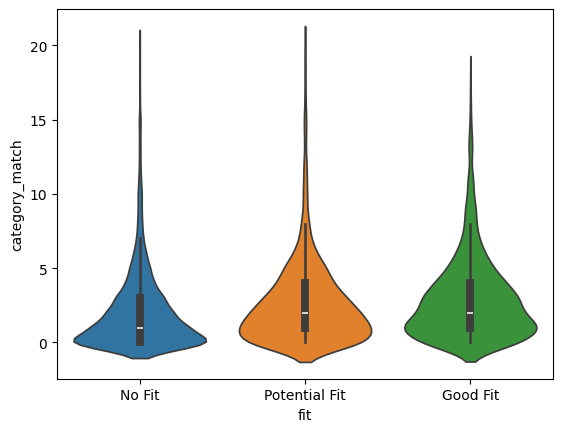

In [61]:
sns.violinplot(data=df_joined_pd, x='fit', y='category_match', hue='fit')

<Axes: xlabel='fit', ylabel='specific_match'>

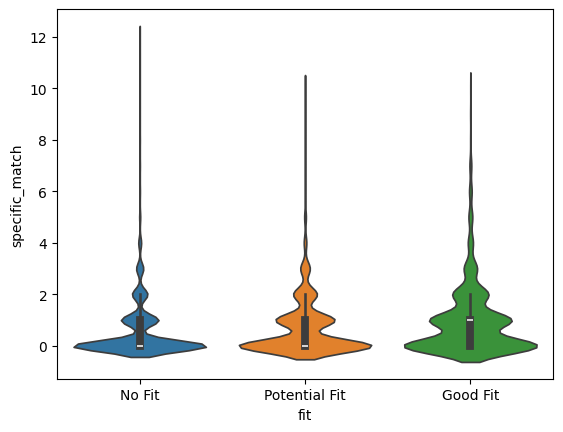

In [62]:
sns.violinplot(data=df_joined_pd, x='fit', y='specific_match', hue='fit')

In [63]:
df_joined_pd['hard_skills_category_y_len'] = df_joined_pd['hard_skills_category_y'].apply(lambda x: len(x) if x is not None else 0)
df_joined_pd['hard_skills_standardized_y_len'] = df_joined_pd['hard_skills_standardized_y'].apply(lambda x: len(x) if x is not None else 0)

df_joined_pd['category_match_ratio'] = df_joined_pd['category_match'] / df_joined_pd['hard_skills_category_y_len']
df_joined_pd['specific_match_ratio'] = df_joined_pd['specific_match'] / df_joined_pd['hard_skills_category_y_len']

<Axes: xlabel='fit', ylabel='category_match_ratio'>

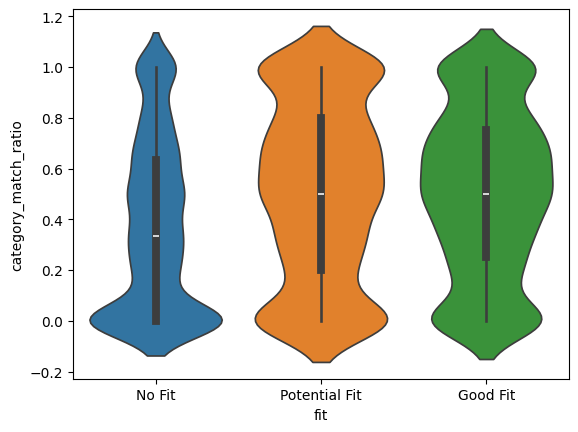

In [64]:
sns.violinplot(data=df_joined_pd, x='fit', y='category_match_ratio', hue='fit')

<Axes: xlabel='fit', ylabel='specific_match_ratio'>

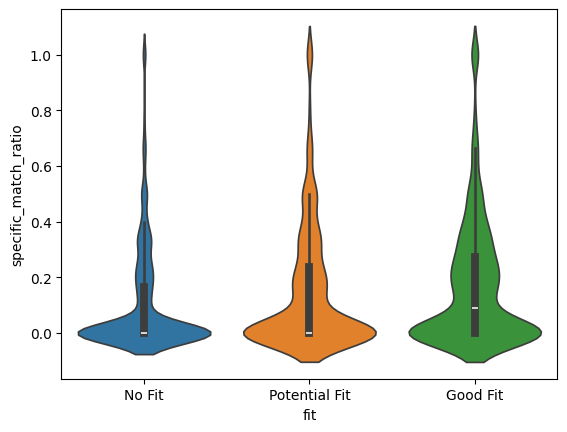

In [65]:
sns.violinplot(data=df_joined_pd, x='fit', y='specific_match_ratio', hue='fit')

## Soft Skills

In [66]:
# Read from cache
df_compare_soft = spark.read.option("header", "true").parquet("datamart/temp/df_compare_soft.parquet")

# Clean soft skills
df_soft_skills_cleaned = df_compare_soft.select('job_id', 'resume_id', 'fit', 'soft_skills_similarity_scores')
# df_soft_skills_cleaned = df_soft_skills_cleaned.withColumn(
#     "soft_skills_matched",
#     F.expr("filter(soft_skills_matched, x -> x is not null)")
# )
# df_soft_skills_cleaned = df_soft_skills_cleaned.withColumn(
#     "soft_skills_matched",
#     F.array_distinct("soft_skills_matched")
# )

In [70]:
df_soft_skills_pd = df_soft_skills_cleaned.toPandas()

In [68]:
df_soft_skills_pd['mean_similarity_score'] = df_soft_skills_pd['soft_skills_similarity_scores'].apply(lambda x: np.mean(x) if x else None)

In [71]:
df_soft_skills_pd.groupby('fit').describe()

job_id                          resume_id                       \
               count unique          top freq     count unique           top   
fit                                                                            
Good Fit        1542   1542  JD_DPqh0lVb    1      1542   1542  RES_DPqh0lVb   
No Fit          3143   3143  JD_iqgmQ9pk    1      3143   3143  RES_iqgmQ9pk   
Potential Fit   1556   1556  JD_m94bSyeq    1      1556   1556  RES_m94bSyeq   

                   soft_skills_similarity_scores         \
              freq                         count unique   
fit                                                       
Good Fit         1                          1384   1352   
No Fit           1                          2638   2557   
Potential Fit    1                          1257   1215   

                                                                       
                                                             top freq  
fit                                                                    
Good Fit       [1.0000001192092896, 0.9999997615814209, 0.999...    7  
No Fit         [1.0000001192092896, 0.9999997615814209, 0.537...    8  
Potential Fit  [1.0000001192092896, 0.9999997615814209, 0.999...    5

<Axes: xlabel='fit', ylabel='mean_similarity_score'>

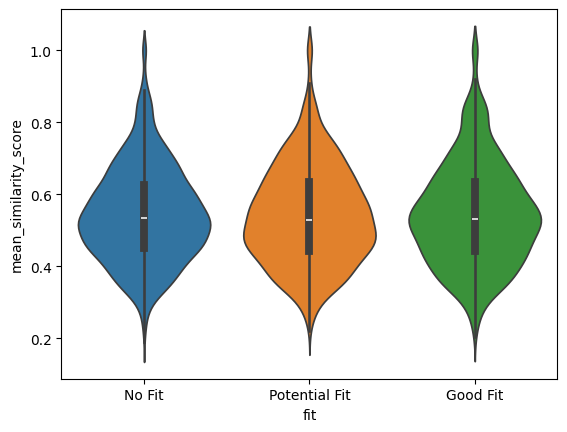

In [26]:
sns.violinplot(df_soft_skills_pd, x="fit", y="mean_similarity_score", hue="fit")

In [76]:
df_soft_skills_pd['count_skill_match'] = df_soft_skills_pd['soft_skills_matched'].apply(lambda x: len(x))
df_soft_skills_pd['count_skill_jd'] = df_soft_skills_pd['jd_soft_skills'].apply(lambda x: len(x))
df_soft_skills_pd['skill_match_ratio'] = df_soft_skills_pd['count_skill_match'] / df_soft_skills_pd['count_skill_jd'] 

<Axes: xlabel='fit', ylabel='count_skill_match'>

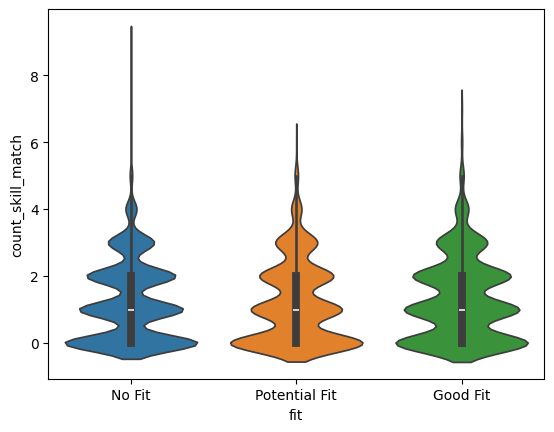

In [79]:
sns.violinplot(data=df_soft_skills_pd, x='fit', y='count_skill_match', hue='fit')

<Axes: xlabel='fit', ylabel='skill_match_ratio'>

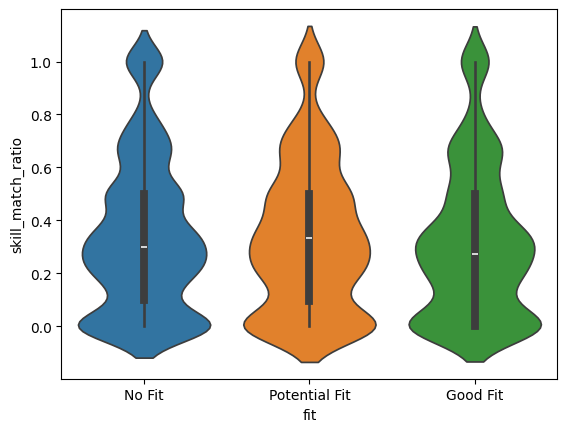

In [80]:
sns.violinplot(data=df_soft_skills_pd, x='fit', y='skill_match_ratio', hue='fit')